In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR
from ler.utils import save_json, load_json

In [2]:
# from ler.gw_source_population import CBCSourceParameterDistribution

# ler = CBCSourceParameterDistribution()

# param_dict = ler.sample_gw_parameters(1000000)

In [3]:
# save_json('param_dict_bbh_1e6.json', param_dict)
param_dict_1e6 = load_json('param_dict_bbh_1e6.json')
# convert to np.array
param_dict_1e6 = {key: np.array(value) for key, value in param_dict_1e6.items()}

## Interpolation

### Numba - CPU

In [4]:
# initializing the GWSNR class with default configuration and interpolation method
# for aligned-spinning IMRPhenomD waveform 
gwsnr = GWSNR(
    snr_type='interpolation_aligned_spins',
    gwsnr_verbose=False,
    mtot_cut=True,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_8.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_8.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_8.pickle




In [24]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(42)
nsamples = np.linspace(1000, 1000000, 10)
def run_time_cal(nsamples):
    
    time_list = []
    for n in nsamples:
        # select n samples for each values in the dict
        idx = np.random.choice(len(param_dict_1e6['mass_1']), size=int(n), replace=False)
        param_dict = {key: value[idx] for key, value in param_dict_1e6.items()}

        # measure the time taken for SNR calculation
        time_ = []
        for _ in range(11):  # repeat 6 times to get an average
            start_time = datetime.now()
            snr = gwsnr.snr_with_interpolation(gw_param_dict=param_dict)
            end_time = datetime.now()
            time_.append((end_time - start_time).total_seconds() * 1000)  # convert to milliseconds

        time_list.append(np.mean(time_[1:]))  # average time over 10 runs

    return nsamples, np.array(time_list)

In [3]:
# _, run_time_numba_cpu = run_time_cal(nsamples)
# # save
# np.save('run_time_numba_cpu.npy', run_time_numba_cpu)
# load
run_time_numba_cpu = np.load('run_time_numba_cpu.npy')

In [13]:
run_time_numba_cpu

array([   4.356 ,  195.8752,  329.1386,  482.7428,  620.5922,
        788.4502,  938.587 , 1099.5354, 1227.898 , 1362.8958])

### JAX - CPU

In [9]:
gwsnr = GWSNR(
    snr_type='interpolation_aligned_spins_jax',
    gwsnr_verbose=False,
    mtot_cut=True,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_8.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_8.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_8.pickle




In [4]:
# _, run_time_jax_cpu = run_time_cal(nsamples)
# # save
# np.save('run_time_jax_cpu.npy', run_time_jax_cpu)
# load
run_time_jax_cpu = np.load('run_time_jax_cpu.npy')

In [11]:
run_time_jax_cpu

array([   5.4564,  197.3658,  376.4862,  557.4246,  733.148 ,
        909.5018, 1085.3078, 1255.8524, 1405.818 , 1589.8646])

### MLX - GPU

In [18]:
gwsnr = GWSNR(
    snr_type='interpolation_aligned_spins_mlx',
    gwsnr_verbose=False,
    mtot_cut=True,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_8.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_8.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_8.pickle




In [5]:
# _, run_time_mlx_gpu = run_time_cal(nsamples)
# # save
# np.save('run_time_mlx_gpu.npy', run_time_mlx_gpu)
# load
run_time_mlx_gpu = np.load('run_time_mlx_gpu.npy')

In [20]:
run_time_mlx_gpu

array([   6.346 ,  103.3834,  198.0804,  286.3992,  390.5948,
        503.4248,  619.2182,  704.8304, 1411.7104,  983.2656])

### JAX - GPU

In [6]:
# tested with Nvidia 3080 GPU
run_time_jax_gpu = np.array([11.159,  26.794,  34.861,  43.266, 100.089, 108.236, 125.064, 131.672, 139.722, 145.458])
# np.save('run_time_jax_gpu.npy', run_time_jax_gpu)

### Plot comparison

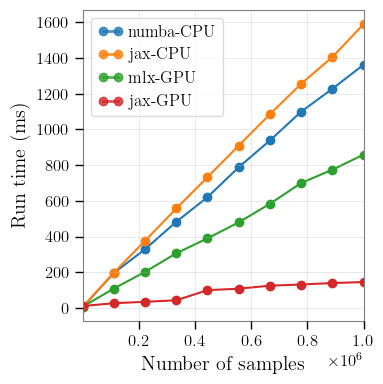

In [19]:
# plotting the run time
plt.figure(figsize=(4, 4))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
np.random.seed(42)
nsamples = np.linspace(1000, 1000000, 10)
plt.plot(nsamples, run_time_numba_cpu, marker='o', linestyle='-', color='C0', label='numba-CPU')
plt.plot(nsamples, run_time_jax_cpu, marker='o', linestyle='-', color='C1', label='jax-CPU')
plt.plot(nsamples, run_time_mlx_gpu, marker='o', linestyle='-', color='C2', label='mlx-GPU')
plt.plot(nsamples, run_time_jax_gpu, marker='o', linestyle='-', color='C3', label='jax-GPU')
plt.xlim(1e3, 1e6)
plt.xlabel('Number of samples')
plt.ylabel('Run time (ms)')
# plt.xscale('log')
# plt.yscale('log')
# legend
legend = plt.legend(handlelength=1.5, loc='upper left', bbox_to_anchor=(0.0, 1.0), frameon=True, fontsize=12, edgecolor='lightgray')
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)

# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)   

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('../_static/interpolation_speed_test.png', dpi=300, bbox_inches='tight')
plt.show()

## Table

<!-- ### Hardware Specifications

#### System 1: Apple Silicon (Primary Testing Environment)
**MacBook Pro (Model: MPHH3ZP/A)**
- **Processor**: Apple M2 Pro (10-core: 6 performance + 4 efficiency cores)
- **GPU**: Apple M2 Pro (16-core GPU with Metal support)
- **Memory**: 16 GB unified memory
- **Architecture**: ARM64 (Apple Silicon)

#### System 2: x86_64 with NVIDIA GPU (Performance Comparison)
**AMD EPYC Workstation**
- **Processor**: AMD EPYC 7502P (32-core, 64 threads)
- **GPU**: NVIDIA GeForce RTX 3080 (GA102 architecture)
- **Memory**: System RAM (specifications not detailed)
- **Architecture**: x86_64
- **Cache Hierarchy**: L1d/L1i: 32KB, L2: 512KB, L3: 16MB -->

### Interpolation Performance

| Hardware Acceleration Type | Machine | Time \[ms\]<br>(BBH/BNS) | Vs. Inner-Product (bilby)<br>(BBH, BNS) |
|:--|:--|:--:|:--:|
| Interpolation (mlx-gpu, multi-threaded) | Apple Silicon M2 pro, GPU | 94 | x864, x104653 |
| Interpolation (jax-gpu, multi-threaded) | NVIDIA GeForce RTX 3080, CIT | 117 | x694, x84081 |
| Interpolation (jax-cpu, multi-threaded) | Apple Silicon M2 pro | 187 | x434, x52606 |
| Interpolation (numba-cpu, multi-threaded) | Apple Silicon M2 pro | 193 | x420, x50971 |

### Inner-Product Performance

| Hardware Acceleration Type | Machine | Time \[s\]<br>(BBH, BNS) | Vs. Inner-Product (bilby)<br>(BBH, BNS) |
|:--|:--|:--|:--|
| Inner-Product (gwsnr, multi-core) | Apple Silicon M2 pro, 4CPU | 38.654, 111.474 | x2.1, x88.2 |
| Inner-Product (bilby, single-core) | Apple Silicon M2 pro, 1CPU | 81.229, 9837.443 | x1, x1 |

In [34]:
111.474*1000/94

1185.8936170212767

In [33]:
9837.443/60/60

2.7326230555555555